### This notebook demonstrates how to train SAraBERT and using as Question and Answering.

## Outlines

- Install/Load the required modules
- Train SAraBERT on two Arabic pair questions Dataset
- Run SAraBERT Model
- Test the Model
- Using model as Word Embedding provider for user Question
- Model Evaluation by Distance and Similarity based metrics
- Error Analysis

In [38]:
!pip install sentence-transformers

In [150]:
from torch.utils.data import DataLoader
from torch import nn
from sentence_transformers import LoggingHandler, SentenceTransformer, util, models, losses
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from sentence_transformers.readers import *
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
import pandas as pd
import datetime
import os
import math
from scipy.stats import spearmanr
from scipy.stats import pearsonr



In [151]:
nli_data = pd.read_json("xnli.dev.jsonl", lines=True)
sts_data = pd.read_csv("train.csv", low_memory=False)
arabic_nli_data = nli_data.loc[nli_data['language']=='ar', :]

sts_data_train, sts_data_test = train_test_split(sts_data, test_size=0.2)

In [152]:
sts_data_train

,question1,question2,label
2891,ما هي طريقة تعديل الشاشة المقلوبة في نظام لينكس؟,ما سبب الشاشة المقلوبة؟,0
7290,من قام باكتشاف مدينة البتراء؟,ما أهمية الموقع الإستراتيجي للبتراء قديماً؟,0
3765,من طرق تحضير سلطة الجبنة البيضاء؟,من طرق تحضير سلطة ؟,0
6961,ما هو مناخ نيجيريا السائد؟,ما المناخ السائد في نيجيريا؟,1
7742,متى تم اكتشاف جزيرة تسمانيا؟,في أي عام تك اكتشاف جزيرة تسمانيا؟,1
...,...,...,...
9169,ماذا نقصد بالباستا فلورا؟,ما هو بالباستا فلورا؟,1
1311,في أي عام كانت غزوة الطائف؟,في أي سنة وقعت غزوة خيبر؟,0
2155,من هم الأشخاص الذين يحظر عليهم تناول الميرمية؟,هل تضر الميرمية المرأة الحامل والمرضع؟,1
187,ما عاصمة أثيوبيا؟,ما هي عاصمة إريتريا؟,0


### Loading BERT Model

In [153]:
# set AraBERT name from Huggingface transformers hosted models - https://huggingface.co/aubmindlab/bert-base-arabertv02
model_name = 'aubmindlab/bert-base-arabertv02'
model_save_path = 'Modelweigths/'
batch_size = 16
max_seq_length=256

# define three modules for sentence embedding model - word embedding, pooling and dense 
word_embedding_model = models.Transformer(model_name, max_seq_length)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(),
                               pooling_mode_mean_tokens=True)
dense_model = models.Dense(in_features=pooling_model.get_sentence_embedding_dimension(), 
                           out_features=256, 
                           activation_function=nn.Tanh())
model = SentenceTransformer(modules=[word_embedding_model, pooling_model, dense_model])

Downloading:   0%|          | 0.00/384 [00:00<?, ?B/s]

C:\Users\Lab 2\anaconda3\lib\site-packages\huggingface_hub\file_download.py:123: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Lab 2\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Downloading:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of the model checkpoint at aubmindlab/bert-base-arabertv02 were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/381 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/825k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.64M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

### Prepare pair questions dataset

In [154]:
label2int = {"contradiction": 0, "entailment": 1, "neutral": 2}
train_nli_samples = []

for index, row in arabic_nli_data.iterrows():
    label_id = label2int[row['gold_label']]
    train_nli_samples.append(InputExample(texts=[row['sentence1'], 
                                          row['sentence2']], 
                                          label=label_id))

train_dataloader_nli = DataLoader(train_nli_samples, 
                                  shuffle=True, 
                                  batch_size=batch_size)
train_loss_nli = losses.SoftmaxLoss(model=model, 
                                    sentence_embedding_dimension=model.get_sentence_embedding_dimension(), 
                                    num_labels=len(label2int))

In [155]:
# show train dataset
sts_data_train

,question1,question2,label
2891,ما هي طريقة تعديل الشاشة المقلوبة في نظام لينكس؟,ما سبب الشاشة المقلوبة؟,0
7290,من قام باكتشاف مدينة البتراء؟,ما أهمية الموقع الإستراتيجي للبتراء قديماً؟,0
3765,من طرق تحضير سلطة الجبنة البيضاء؟,من طرق تحضير سلطة ؟,0
6961,ما هو مناخ نيجيريا السائد؟,ما المناخ السائد في نيجيريا؟,1
7742,متى تم اكتشاف جزيرة تسمانيا؟,في أي عام تك اكتشاف جزيرة تسمانيا؟,1
...,...,...,...
9169,ماذا نقصد بالباستا فلورا؟,ما هو بالباستا فلورا؟,1
1311,في أي عام كانت غزوة الطائف؟,في أي سنة وقعت غزوة خيبر؟,0
2155,من هم الأشخاص الذين يحظر عليهم تناول الميرمية؟,هل تضر الميرمية المرأة الحامل والمرضع؟,1
187,ما عاصمة أثيوبيا؟,ما هي عاصمة إريتريا؟,0


In [156]:
# show test dataset
sts_data_test

,question1,question2,label
1610,من ماذا يتكون الاسمنت ؟,ما هي مكونات الاسمنت ؟,1
4224,ما طريقة تحضير حلقوم البرتقال؟,من طرق تحضير الحلقوم ؟,0
695,ما معنى التفويض الجزئي ؟,ما مفهوم التفويض المشروط؟,0
11476,ما هي صورة ال selfe؟,من اخترع الصورة الذاتية؟,0
9468,من قائل قصيدة أمطرت لؤلؤاً؟,ما هي مناسبة قصيدة أمطرت لؤلؤاً؟,0
...,...,...,...
138,ما طريقة تحضير العصيدة مع الجبن ؟,كيف احضر العصيدة مع الجبن؟,1
1637,من طرق تحضير قلاية البندوة بالثوم ؟,من طرق تحضير قلاية البندوة ؟,0
11248,ما السبب في عدم قابلية جهاز الأندرويد على التح...,ما السبب في أنّ جهازي الأندرويد غير قابل للتحديث؟,1
9596,ما هي اللغة المعتمدة في جزر القمر؟,ما عملة جزر القمر؟,0


In [157]:
train_sts_samples = []
dev_sts_samples = []

for index, row in sts_data_train.iterrows():
    label_id = float(row['label'])
    train_sts_samples.append(InputExample(texts=[row['question1'], 
                                          row['question2']], 
                                          label=label_id))
                                          
for index, row in sts_data_test.iterrows():
    label_id = float(row['label'])
    dev_sts_samples.append(InputExample(texts=[row['question1'], 
                                        row['question2']], 
                                        label=label_id))
                                        
train_dataloader_sts = DataLoader(train_sts_samples, 
                                  shuffle=True, 
                                  batch_size=batch_size)
train_loss_sts = losses.CosineSimilarityLoss(model=model)
evaluator = EmbeddingSimilarityEvaluator.from_input_examples(dev_sts_samples, name='sts-dev')

## Fine tuning SAraBERT model on two different  Arabic dataset

In [ ]:
num_epochs = 4
warmup_steps = math.ceil(len(train_dataloader_sts) * num_epochs * 0.1) 
evaluation_steps=1000
# set up multi-task learning training objectives
train_objectives = [(train_dataloader_nli, train_loss_nli), (train_dataloader_sts, train_loss_sts)]

model.fit(train_objectives=train_objectives,
          evaluator=evaluator,
          epochs=num_epochs,
          evaluation_steps=evaluation_steps,
          warmup_steps=warmup_steps,
          output_path=model_save_path)

## Load save weights

In [42]:
#sts_data_val = pd.read_csv("test.csv", low_memory=False)
model_save_path="Modelweigths/"
test_sts_samples = []

for index, row in sts_data_test.iterrows():
    label_id = float(row['label'])
    test_sts_samples.append(InputExample(texts=[row['question1'], 
                                         row['question2']], 
                                         label=label_id))
                                         
model = SentenceTransformer(model_save_path)
test_evaluator = EmbeddingSimilarityEvaluator.from_input_examples(test_sts_samples, name='sts-test')
test_evaluator(model, output_path=model_save_path)

0.8228044864921126

## Model evaluation 
 Using created questions from Bank policies

In [43]:
data_created=pd.read_excel("polices.xlsx")

In [44]:
data_created

,questions,answers,questions_2
0,ما هو هدف السياسة النقدية ؟,يعهد قانون البنك المركزى والجهاز المصرفى والنق...,ايه هو هدف السياسة النقدية؟
1,ماذا يفعل البنك المركزى المصرى حتى يتحول إلى ن...,يطمح البنك المركزى المصرى فى تطبيق إستهداف الت...,كيف يمكن يتحول البنك المركزى الى نظام مكتمل؟
2,كيف تقرر لجنة السياسة النقدية أسعار العائد ؟,تعرض على لجنة السياسة النقدية التقارير والدراس...,ازاى تقرر لجنة السياسات النقدية سعر العائد؟
3,ما هى لجنة السياسة النقدية ؟,تتكون لجنة السياسة النقدية التى تم تشكيلها بقر...,ما هى لجنة السياسات النقدية؟
4,ما هو دور البنك المركزي السعودي في تنظيم علاقة...,يعتبر البنك المركزي السعودي الجهة الإشرافية وا...,ايه هو دور البنك المركزى السعودى في تنظيم العل...
5,ما هي آلية استقبال شكاوى العملاء في البنك المر...,في حال عدم قناعة الشاكي بنتائج معالجة شكواه لد...,ما هي طريقة استقبال الشكاوى من العملاء في البن...
6,ما هي قنوات استقبال الشكاوى في البنك المركزي ا...,إدارة حماية العملاء بالمركز الرئيسي في البنك ...,ايه هي طرق استقبال الشكاوى في البنك المركزى ال...
7,هل يحق للبنك أخذ رسوم إصدار بطاقات الصرف الآلي؟,اشتملت التعرفة البنكية الصادرة من البنك المركز...,هل يعتبر حق البنك في اخذ رسوم اصدار بطاقات الصرف؟
8,هل يحق للبنك المطالبة بسداد مستحقات البطاقات ا...,يختلف ذلك حسب نوع البطاقة، فهناك بطاقات الخصم ...,هل من حق البنك ان يطالب بسداد مستحقات البطاقة ...
9,هل يحق للبنك خصم مستحقات البطاقات الائتمانية م...,يخضع هذا الاجراء إلى الاتفاقية المبرمة بين الب...,هل من حق البنك ان يخصم مستحقات البطاقة الائتما...


## Similarity Based Metrics

###  Cosine Similarity

In [111]:
accuracies=[]
for i in range(len(data_created)):
    embedding_11 = model.encode(str(data_created.iloc[i][0]), convert_to_tensor=True)
    embedding_22 = model.encode(str(data_created.iloc[i][2]), convert_to_tensor=True)
    co_scores = util.pytorch_cos_sim(embedding_11, embedding_22)
    co_scores=co_scores.numpy()
    accuracies.append(co_scores[0][0])
    print(data_created.iloc[i][0]," Score:",co_scores[0][0])

cosine_score=(sum(accuracies)/len(data_created))
print("Accuracy depend on cosine similarity:",cosine_score)

#print(max(),accuracies[knnclass_test_accuracies.index(max(knnclass_test_accuracies))])           

ما هو هدف السياسة النقدية ؟   Score: 0.99123085
ماذا يفعل البنك المركزى المصرى حتى يتحول إلى نظام مكتمل الملامح لإستهداف التضخم (Inflation Targeting Regime) ؟  Score: 0.416848
كيف تقرر لجنة السياسة النقدية أسعار العائد ؟  Score: 0.895322
ما هى لجنة السياسة النقدية ؟  Score: 0.9744335
ما هو دور البنك المركزي السعودي في تنظيم علاقة البنوك وشركات التأمين وشركات التمويل مع عملاءه؟  Score: 0.91221493
ما هي آلية استقبال شكاوى العملاء في البنك المركزي السعودي؟
  Score: 0.86136025
ما هي قنوات استقبال الشكاوى في البنك المركزي السعودي؟  Score: 0.8437573
هل يحق للبنك أخذ رسوم إصدار بطاقات الصرف الآلي؟  Score: 0.8119611
هل يحق للبنك المطالبة بسداد مستحقات البطاقات الائتمانية بالكامل؟  Score: 0.76349866
هل يحق للبنك خصم مستحقات البطاقات الائتمانية من حساب العميل مباشرة؟  Score: 0.92215466
هل يحق للبنك رفض إصدار ومنح العميل بطاقة ائتمانية؟  Score: 0.9142631
هل يحق للبنك عند منح العميل بطاقة ائتمانية إدراج تفاصيل بيانات البطاقة في الشركة السعودية للمعلومات الائتمانية "سمة"؟  Score: 0.89862686
هل يحق 

In [36]:
accuracies

[tensor([[0.9912]]),
 tensor([[0.4168]]),
 tensor([[0.8953]]),
 tensor([[0.9744]]),
 tensor([[0.9122]]),
 tensor([[0.8614]]),
 tensor([[0.8438]]),
 tensor([[0.8120]]),
 tensor([[0.7635]]),
 tensor([[0.9222]]),
 tensor([[0.9143]]),
 tensor([[0.8986]]),
 tensor([[0.9531]]),
 tensor([[0.7281]]),
 tensor([[0.7610]]),
 tensor([[0.9314]]),
 tensor([[0.9010]]),
 tensor([[0.6918]]),
 tensor([[0.9074]]),
 tensor([[0.9170]]),
 tensor([[0.9151]]),
 tensor([[0.9481]]),
 tensor([[0.9859]]),
 tensor([[0.9502]]),
 tensor([[0.9385]]),
 tensor([[0.8948]]),
 tensor([[0.8803]]),
 tensor([[0.9366]]),
 tensor([[0.9137]]),
 tensor([[0.9677]]),
 tensor([[0.8656]]),
 tensor([[0.9526]]),
 tensor([[0.9003]]),
 tensor([[0.8807]]),
 tensor([[0.8426]]),
 tensor([[0.9199]]),
 tensor([[0.8852]]),
 tensor([[0.9479]]),
 tensor([[0.8933]]),
 tensor([[0.8761]]),
 tensor([[0.9050]]),
 tensor([[0.9374]]),
 tensor([[0.9432]]),
 tensor([[0.7998]]),
 tensor([[0.9321]]),
 tensor([[0.8870]]),
 tensor([[0.9232]]),
 tensor([[0.9

In [71]:
from numpy import array
scoreee=(sum(accuracies)/len(data_created)).numpy()

In [74]:
print("Correlation Average using Cosine Similarity =",scoreee[0][0])

Accuracy of Cosine Similarity = 0.8879555


###  Pearson’s correlation and Spearman’s  correlation   

In [113]:
spearman_corr=[]
pearson_corr=[]

for i in range(len(data_created)):
    embedding_11 = model.encode(str(data_created.iloc[i][0]), convert_to_tensor=True)
    embedding_22 = model.encode(str(data_created.iloc[i][2]), convert_to_tensor=True)
    sp_corr, _ = spearmanr(embedding_11, embedding_22)
    ps_corr, _ = pearsonr(embedding_11, embedding_22)  
    spearman_corr.append(sp_corr)
    pearson_corr.append(ps_corr)
    print("spearman's score=",sp_corr, " pearson's score=",ps_corr," \n",data_created.iloc[i][0], "  ",data_created.iloc[i][2],"\n")
pears_score =sum(pearson_corr)/len(data_created)
spear_score =sum(spearman_corr)/len(data_created)
print("Pearson’s Average correlation =",pears_score)
print("Spearman’s Average correlation =",spear_score)

spearman's score= 0.990783073929961  pearson's score= 0.9912713744248481  
 ما هو هدف السياسة النقدية ؟     ايه هو هدف السياسة النقدية؟ 

spearman's score= 0.4255042629892423  pearson's score= 0.4231694627571162  
 ماذا يفعل البنك المركزى المصرى حتى يتحول إلى نظام مكتمل الملامح لإستهداف التضخم (Inflation Targeting Regime) ؟    كيف يمكن يتحول البنك المركزى الى نظام مكتمل؟ 

spearman's score= 0.8900713836118105  pearson's score= 0.8958900573252881  
 كيف تقرر لجنة السياسة النقدية أسعار العائد ؟    ازاى تقرر لجنة السياسات النقدية سعر العائد؟ 

spearman's score= 0.9704051270313571  pearson's score= 0.9743708417524279  
 ما هى لجنة السياسة النقدية ؟     ما هى لجنة السياسات النقدية؟ 

spearman's score= 0.9074459258411535  pearson's score= 0.9123075800235503  
 ما هو دور البنك المركزي السعودي في تنظيم علاقة البنوك وشركات التأمين وشركات التمويل مع عملاءه؟    ايه هو دور البنك المركزى السعودى في تنظيم العلاقات بين البنوك  و شركات التمويل مع العملاء و شركات التامين ؟  

spearman's score= 0.845043

## **Distance Based Metrics**

###  Manhatan Distance

In [104]:
manh_distances=[]
for i in range(len(data_created)):
    embedding_11 = model.encode(str(data_created.iloc[i][0]), convert_to_tensor=True)
    embedding_22 = model.encode(str(data_created.iloc[i][2]), convert_to_tensor=True)
    dst = distance.cityblock(embedding_11,embedding_22)
    print("Manhatan distance =",dst, " \n",data_created.iloc[i][0], "  ",data_created.iloc[i][2],"\n")
    manh_distances.append(dst)
#     print(data_created.iloc[i][0]," Manhatan Distance:",cosine_scores)

manh_score=sum(manh_distances)/len(data_created)
print("Average distance using Manhatan distance:",manh_score)

Manhatan distance = 11.153765  
 ما هو هدف السياسة النقدية ؟     ايه هو هدف السياسة النقدية؟ 

Manhatan distance = 92.04122  
 ماذا يفعل البنك المركزى المصرى حتى يتحول إلى نظام مكتمل الملامح لإستهداف التضخم (Inflation Targeting Regime) ؟    كيف يمكن يتحول البنك المركزى الى نظام مكتمل؟ 

Manhatan distance = 37.955826  
 كيف تقرر لجنة السياسة النقدية أسعار العائد ؟    ازاى تقرر لجنة السياسات النقدية سعر العائد؟ 

Manhatan distance = 17.638258  
 ما هى لجنة السياسة النقدية ؟     ما هى لجنة السياسات النقدية؟ 

Manhatan distance = 33.898445  
 ما هو دور البنك المركزي السعودي في تنظيم علاقة البنوك وشركات التأمين وشركات التمويل مع عملاءه؟    ايه هو دور البنك المركزى السعودى في تنظيم العلاقات بين البنوك  و شركات التمويل مع العملاء و شركات التامين ؟  

Manhatan distance = 42.752  
 ما هي آلية استقبال شكاوى العملاء في البنك المركزي السعودي؟
    ما هي طريقة استقبال الشكاوى من العملاء في البنك المركزى السعودى؟ 

Manhatan distance = 44.221794  
 ما هي قنوات استقبال الشكاوى في البنك المركزي السعودي؟

###  Euclidean distance

In [105]:
eucli_distances=[]
for i in range(len(data_created)):
    embedding_11 = model.encode(str(data_created.iloc[i][0]), convert_to_tensor=True)
    embedding_22 = model.encode(str(data_created.iloc[i][2]), convert_to_tensor=True)
    dst = distance.euclidean(embedding_11,embedding_22)
    print("Euclidean distance =",dst, " \n",data_created.iloc[i][0], "  ",data_created.iloc[i][2],"\n")
    eucli_distances.append(dst)
#     print(data_created.iloc[i][0]," Manhatan Distance:",cosine_scores)

eucl_score=sum(eucli_distances)/len(data_created)
print("Average distance using Euclidean distance:",eucl_score)

Euclidean distance = 0.8739078044891357  
 ما هو هدف السياسة النقدية ؟     ايه هو هدف السياسة النقدية؟ 

Euclidean distance = 7.15518856048584  
 ماذا يفعل البنك المركزى المصرى حتى يتحول إلى نظام مكتمل الملامح لإستهداف التضخم (Inflation Targeting Regime) ؟    كيف يمكن يتحول البنك المركزى الى نظام مكتمل؟ 

Euclidean distance = 2.9489798545837402  
 كيف تقرر لجنة السياسة النقدية أسعار العائد ؟    ازاى تقرر لجنة السياسات النقدية سعر العائد؟ 

Euclidean distance = 1.3960762023925781  
 ما هى لجنة السياسة النقدية ؟     ما هى لجنة السياسات النقدية؟ 

Euclidean distance = 2.7401583194732666  
 ما هو دور البنك المركزي السعودي في تنظيم علاقة البنوك وشركات التأمين وشركات التمويل مع عملاءه؟    ايه هو دور البنك المركزى السعودى في تنظيم العلاقات بين البنوك  و شركات التمويل مع العملاء و شركات التامين ؟  

Euclidean distance = 3.286426305770874  
 ما هي آلية استقبال شكاوى العملاء في البنك المركزي السعودي؟
    ما هي طريقة استقبال الشكاوى من العملاء في البنك المركزى السعودى؟ 

Euclidean distance = 3.49

## Visualization of results

## Correlation Metrics

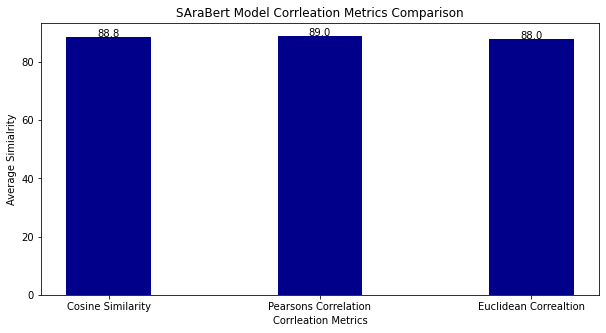

In [142]:
import numpy as np
import matplotlib.pyplot as plt
 
x_axis=["Cosine Similarity","Pearsons Correlation","Euclidean Correaltion"]
values=[round(cosine_score,3)*100, round(pears_score,3)*100 ,round(spear_score,3) *100]

fig = plt.figure(figsize = (10, 5))

for i in range(len(values)):
    plt.text(i, values[i], values[i], ha = 'center')
    
# creating the bar plot
plt.bar(x_axis, values, color ='darkblue',
        width = 0.4)
 
plt.xlabel("Corrleation Metrics")
plt.ylabel("Average Simialrity")
plt.title("SAraBert Model Corrleation Metrics Comparison")
plt.show()

## Distance Metrics

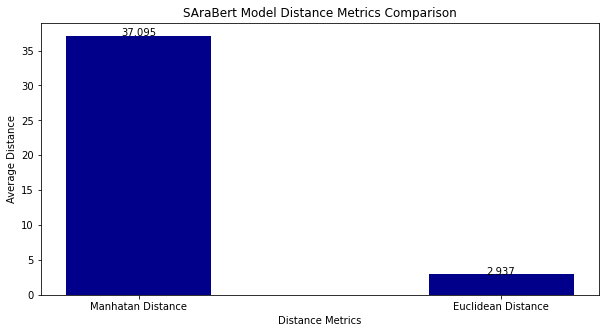

In [144]:
import numpy as np
import matplotlib.pyplot as plt
 
x_axis=["Manhatan Distance","Euclidean Distance"]
values=[round(manh_score,3),round(eucl_score,3)]



fig = plt.figure(figsize = (10, 5))


for i in range(len(values)):
    plt.text(i, values[i], values[i], ha = 'center')

# creating the bar plot
plt.bar(x_axis, values, color ='darkblue',
        width = 0.4)
 
plt.xlabel("Distance Metrics")
plt.ylabel("Average Distance")
plt.title("SAraBert Model Distance Metrics Comparison")
plt.show()

## Error Analysis

### Question in Database

In [146]:
data_created.iloc[30][0]

'هل يحق للبنك رفض منح العميل قرض شخصي؟  '

### A change in the wording of the question but the same meaning

In [147]:
 tst="هل يمكن للبنك ان يرفض منح العملاء قروض شخصية؟"

### Test

In [149]:
accuracies=[]
for i in range(len(data_created)):
    embedding_11 = model.encode(str(data_created.iloc[i][0]), convert_to_tensor=True)
    embedding_22 = model.encode(str(tst), convert_to_tensor=True)
    co_scores = util.pytorch_cos_sim(embedding_11, embedding_22)
    co_scores=co_scores.numpy()
    accuracies.append(co_scores[0][0])
    print(data_created.iloc[i][0]," Score:",co_scores[0][0])


ما هو هدف السياسة النقدية ؟   Score: 0.0492002
ماذا يفعل البنك المركزى المصرى حتى يتحول إلى نظام مكتمل الملامح لإستهداف التضخم (Inflation Targeting Regime) ؟  Score: 0.1260727
كيف تقرر لجنة السياسة النقدية أسعار العائد ؟  Score: 0.32930672
ما هى لجنة السياسة النقدية ؟  Score: -0.18907256
ما هو دور البنك المركزي السعودي في تنظيم علاقة البنوك وشركات التأمين وشركات التمويل مع عملاءه؟  Score: 0.16683547
ما هي آلية استقبال شكاوى العملاء في البنك المركزي السعودي؟
  Score: 0.16014744
ما هي قنوات استقبال الشكاوى في البنك المركزي السعودي؟  Score: 0.1398384
هل يحق للبنك أخذ رسوم إصدار بطاقات الصرف الآلي؟  Score: 0.16109662
هل يحق للبنك المطالبة بسداد مستحقات البطاقات الائتمانية بالكامل؟  Score: 0.22367147
هل يحق للبنك خصم مستحقات البطاقات الائتمانية من حساب العميل مباشرة؟  Score: 0.2094495
هل يحق للبنك رفض إصدار ومنح العميل بطاقة ائتمانية؟  Score: 0.63568103
هل يحق للبنك عند منح العميل بطاقة ائتمانية إدراج تفاصيل بيانات البطاقة في الشركة السعودية للمعلومات الائتمانية "سمة"؟  Score: 0.0771574
هل 